# This notebook is a test version of Zeta.ipynb to test a several models for measuring the drop in $f_{features}$ in the FERENGI-fied galaxies. Refer to the link below for the final version, where zeta is calculated with the chosen model. 

Link to Zeta.ipynb: https://github.com/willettk/gzhubble/blob/master/python/creating_debiased_catalog/STEP_2_zeta.ipynb

## We will use the AIC parameter to evaluate which model is the most appropriate. 

The Akaike information criterion is a measure of relative quality of statistical models to a set of data. It is defined as:

## AIC = 2k - ln(L)

Where k is the number of parameters in the model and L is the maximum value of the likelhihood function for the model. It is applicable for non-nested functions, which is necessary in our case in that we wish to test different types of models. A low AIC value favors both high goodness-of-fit (measured by L) and low complexity (as measured by the number of parameters, k). Therefore the model with the lowest AIC is the preferred model. 

In [11]:
%matplotlib inline

from matplotlib import pyplot as plt
from astropy.table import Table,Column
from astropy.io import fits
from scipy.stats import distributions as dist
import numpy as np
import matplotlib.gridspec as gridspec

from scipy.optimize import minimize
import scipy.stats as stats
import random
import os
import requests
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=UserWarning, append=True)
plt.rcParams['text.usetex']=True
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20 



In [2]:
ferengi_filename = '/home/mel/Dropbox/gzhubble/ferengi_files/ferengi_data_with_categories_new_sb.fits'
alldata = Table.read(ferengi_filename)    

data = alldata[alldata['Correctable_Category'] == 'correctable']


# Fit data with several models, calculate AIC for each fit. Check distributions of each. 

In [4]:
#linear regression 
def regressLL(params):
    # Resave the initial parameter guesses
    b0 = params[0]
    b1 = params[1]
    sd = params[2]

    # Calculate the predicted values from the initial parameter guesses
    yPred = b0 + b1*x

    # Calculate the negative log-likelihood as the negative sum of the log of a normal
    # PDF where the observed values are normally distributed around the mean (yPred)
    # with a standard deviation of sd
    logLik = -np.sum( stats.norm.logpdf(y, loc=yPred, scale=sd) )

    # Tell the function to return the NLL (this is what will be minimized)
    return(logLik)

#exponential 
def exp(params):
    # Resave the initial parameter guesses
    p0 = params[0]
    sd = params[1]

    # Calculate the predicted values from the initial parameter guesses
    z0=0.3
    yPred = np.exp(-1 * (x-z0)/p0)

    # Calculate the negative log-likelihood as the negative sum of the log of a normal
    # PDF where the observed values are normally distributed around the mean (yPred)
    # with a standard deviation of sd
    logLik = -np.sum( stats.norm.logpdf(y, loc=yPred, scale=sd) )

    # Tell the function to return the NLL (this is what will be minimized)
    return(logLik)


#linear with interactions 
def lin_int(params):
    # Resave the initial parameter guesses
    p0 = params[0]
    p1 = params[1]
    p2 = params[2]
    p12 = params[3]
    sd = params[4]

    # Calculate the predicted values from the initial parameter guesses
    yPred = p0 + p1*x + p2*mu + p12*x*mu
    # Calculate the negative log-likelihood as the negative sum of the log of a normal
    # PDF where the observed values are normally distributed around the mean (yPred)
    # with a standard deviation of sd
    logLik = -np.sum( stats.norm.logpdf(y, loc=yPred, scale=sd) )

    # Tell the function to return the NLL (this is what will be minimized)
    return(logLik)


def fit_model(regress_function,initParams):

    results = minimize(regress_function, initParams, method='nelder-mead')
    return results

def get_AIC(k,nll):
    log_likelihood = -nll
    L = 10**(log_likelihood)
    AIC = 2*k - np.log(L)
    return AIC

def error_bars(k,n=40,c=0.683):

    f_gal_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    f_gal_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    f_gal_err = (f_gal_upper - f_gal_lower) / 2.0
    
    return f_gal_err

In [5]:
# Store 
fit_dct={}
# get all unique galaxies
unique_galaxies = set(data['sdss_id'])

for gal in unique_galaxies:

    #loop over different evolutions for each galaxy
    this_galaxy = data[data['sdss_id']==gal]
    for evo in set(this_galaxy['sim_evolution']):
        # Find data for this galaxy at all redshifts
        
        ind = this_galaxy['sim_evolution']==evo

        #Make sure minimum simulated redshift is 0.3; some were removed because of bad surface brightness measurments
        if np.min(this_galaxy[ind]['sim_redshift'])<0.4:
            
            #Store data for each galaxy/evo combination:
            galaxy = this_galaxy[ind]
            galaxy.sort('sim_redshift') #make sure data is in order, helps for plotting later
            fit_dct['id_{:d}_evo_{:.1f}'.format(gal,evo)]={}
            fit_dct['id_{:d}_evo_{:.1f}'.format(gal,evo)]['mu']=galaxy['GZ_MU_I'][0]
                
            #arrays for storing info:
            # set x,y
            x = np.array(galaxy['sim_redshift'])
            y_abs = np.array(galaxy['p_features']) #unnormlaized p_features for galaxy
            p_at_3 = galaxy[galaxy['sim_redshift']==0.3]['p_features'][0]
            y = y_abs/p_at_3 #normalized p_features
            
            n=40
            y_err = error_bars(y_abs*n,n)

            y_norm_err = np.sqrt((y_err/y_abs)**2 + (y_err[0]/y_abs[0])**2) * y

                
            fit_dct['id_{:d}_evo_{:.1f}'.format(gal,evo)]['sim_redshifts']=x
            fit_dct['id_{:d}_evo_{:.1f}'.format(gal,evo)]['norm_f_features']=y
            fit_dct['id_{:d}_evo_{:.1f}'.format(gal,evo)]['y_err']=y_norm_err


            #Now fit stuff: 
            if sum(ind) > 3: # require at least 3 points to fit:

            #1: Linear
                results_linear = fit_model(regressLL,[1,1,1])
                AIC = get_AIC(3,results_linear.fun)
                fit_dct['id_{:d}_evo_{:.1f}'.format(gal,evo)]['linear_AIC']=AIC
                
            #2: Exponential:
                results_exp = fit_model(exp,[1,1])
                AIC = get_AIC(2,results_exp.fun)
                fit_dct['id_{:d}_evo_{:.1f}'.format(gal,evo)]['exp_AIC']=AIC
                
            #3: Linear with Interactions:
                mu = np.array(galaxy['GZ_MU_I']) #surface brightness assumed dependence in this one
                results_lin_int = fit_model(lin_int,[1,1,1,1,1])
                AIC = get_AIC(5,results_lin_int.fun)
                fit_dct['id_{:d}_evo_{:.1f}'.format(gal,evo)]['lin_int_AIC']=AIC




## Compare overall distributions of AIC values for each of the 3 fits:

In [6]:
linear_AICs = [fit_dct[key]['linear_AIC'] for key in fit_dct if 'linear_AIC' in fit_dct[key]]
exp_AICs = [fit_dct[key]['exp_AIC'] for key in fit_dct if 'exp_AIC' in fit_dct[key]]
lin_int_AICs = [fit_dct[key]['lin_int_AIC'] for key in fit_dct if 'lin_int_AIC' in fit_dct[key]]


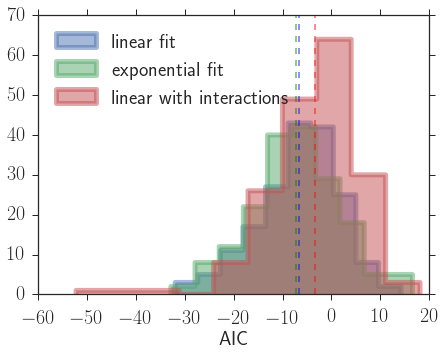

In [7]:
#Compare AIC values:
import seaborn as sns
sns.set(style="ticks")

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20 

f=plt.figure(figsize=(7,5))
plt.hist(linear_AICs,label = 'linear fit',alpha=0.5,histtype='step',fill=True,lw=5)
plt.hist(exp_AICs,label = 'exponential fit',alpha=0.5,histtype='step',fill=True,lw=5)
plt.hist(lin_int_AICs,label = 'linear with interactions',alpha=0.5,histtype='step',fill=True,lw=5)
plt.xlabel('AIC',fontsize=20)
plt.legend(loc=2,fontsize=20)
plt.axvline(x=np.mean(linear_AICs),c='b',alpha=0.5,ls='dashed')
plt.axvline(x=np.mean(exp_AICs),c='g',alpha=0.5,ls='dashed')
plt.axvline(x=np.mean(lin_int_AICs),c='r',alpha=0.5,ls='dashed')

## Exponential is considered the best of the three models based on the AIC parameter, followed by linear fit. 

## Compare AIC values from for each galaxy/evo combo:


(-40, 20)

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


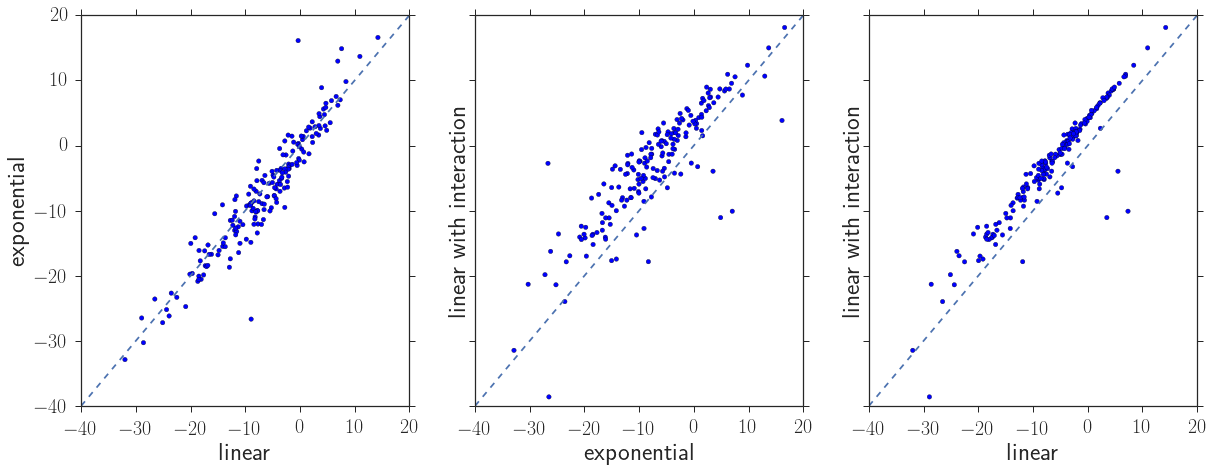

In [8]:
f=plt.figure(figsize=(20,7))
gs = gridspec.GridSpec(1,3)
x = np.linspace(-40,20)
fs = 25

#linear vs exp
ax = plt.subplot(gs[0,0])
plt.scatter(linear_AICs,exp_AICs)
plt.xlabel('linear',fontsize=fs)
plt.ylabel('exponential',fontsize=fs)
plt.plot(x,x,ls='dashed')
plt.xlim(-40,20)
plt.ylim(-40,20)

#exp vs lin_int
ax = plt.subplot(gs[0,1])
plt.scatter(exp_AICs,lin_int_AICs)
plt.plot(x,x,ls='dashed')
plt.tick_params(labelleft='off')
plt.xlabel('exponential',fontsize=fs)
plt.ylabel('linear with interaction',fontsize=fs)
plt.xlim(-40,20)
plt.ylim(-40,20)
#linear vs lin_int
ax = plt.subplot(gs[0,2])
plt.scatter(linear_AICs,lin_int_AICs)
plt.plot(x,x,ls='dashed')
plt.tick_params(labelleft='off')
plt.xlabel('linear',fontsize=fs)
plt.ylabel('linear with interaction',fontsize=fs)
plt.xlim(-40,20)
plt.ylim(-40,20)


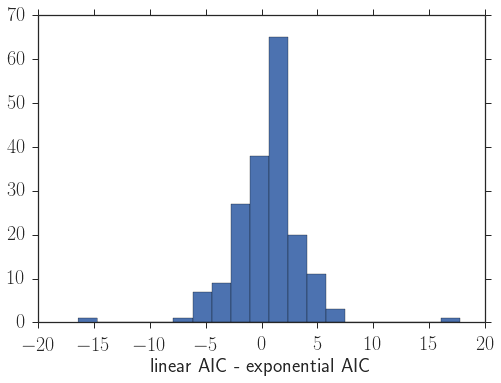

In [9]:
plt.hist([a_i - b_i for a_i, b_i in zip(linear_AICs, exp_AICs)],bins=20)
plt.xlabel('linear AIC - exponential AIC',fontsize=20)


## Plot some examples of fits

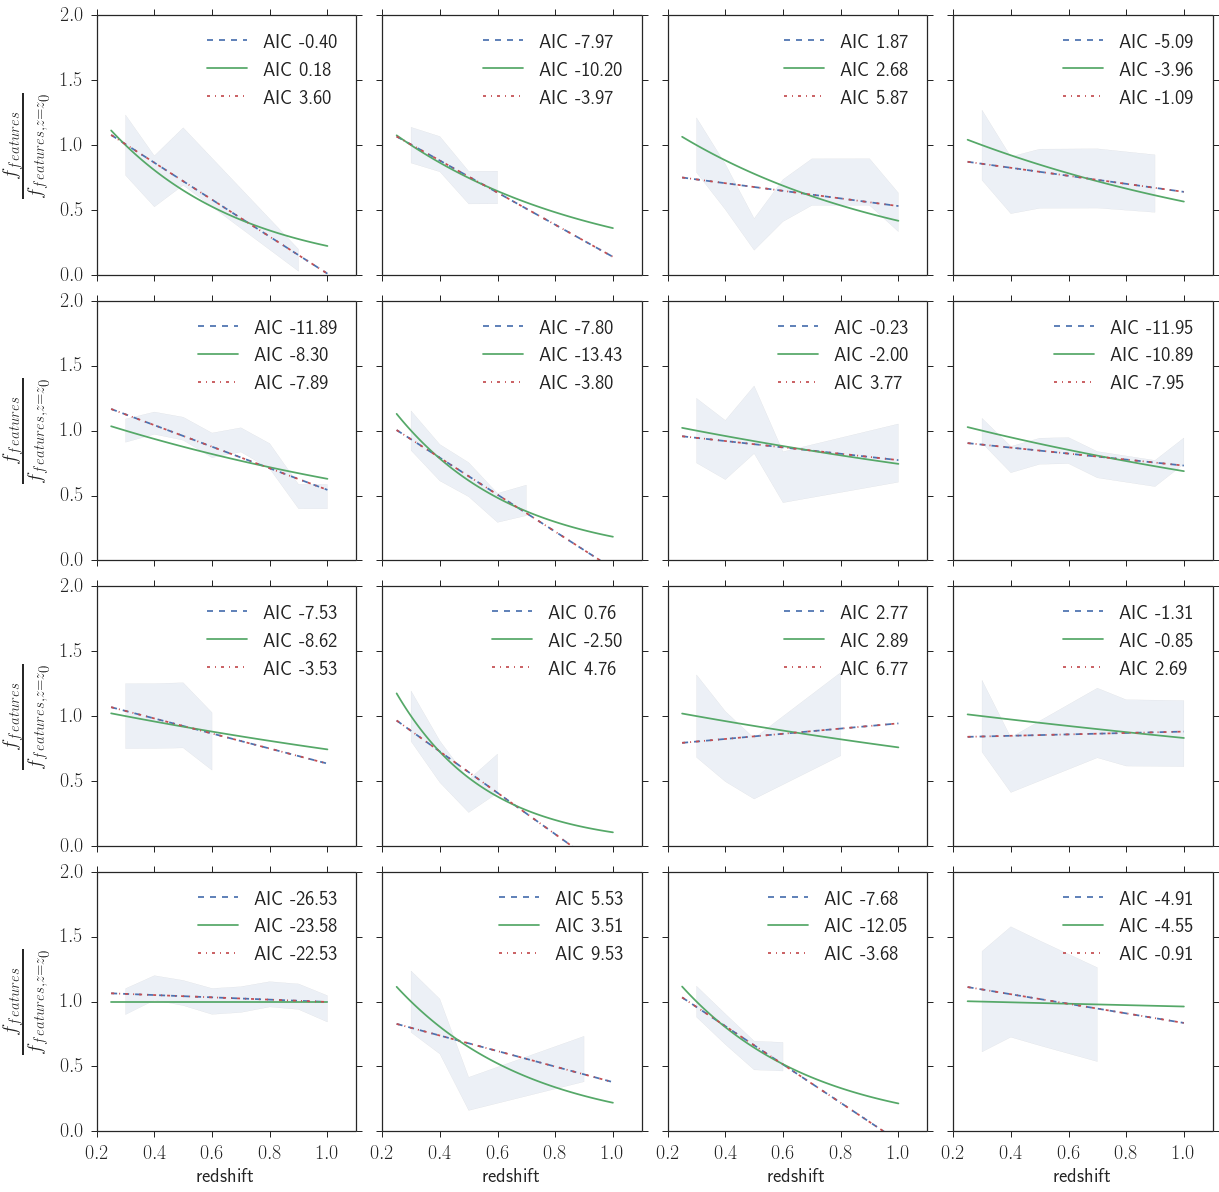

In [27]:
i=0
f = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(4,4)
gs.update(wspace=0.1,hspace=0.1)
gsx = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
gsy = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
xf = np.linspace(.25,1,100)
while i<16:    
    key = random.choice(fit_dct.keys())# random galaxy in fit_dct
    #only did fits for galaxies with at least 3 points, but for examples show ones with at least 4 because pretty. 
    if len(fit_dct[key]['sim_redshifts'])>3:
        ax = plt.subplot(gs[int(gsx[i]),int(gsy[i])])
        if gsx[i]<3:
            plt.tick_params(labelbottom='off')
        else:
            plt.xlabel(r'redshift',fontsize=20)        
        if gsy[i]>0:
            plt.tick_params(labelleft='off')
        else:
            plt.ylabel(r'$\frac{f_{features}}{f_{features,z=z_0}}$',fontsize=30)

        x = fit_dct[key]['sim_redshifts']
        y = fit_dct[key]['norm_f_features']
        y_err = fit_dct[key]['y_err']
        #plt.errorbar(x,y,y_err)
        plt.fill_between(x,y-y_err,y+y_err,alpha=0.1)
        
        #linear fit:
        results_linear = fit_model(regressLL,[1,1,1])
        l_AIC = get_AIC(3,results_linear.fun)

        plt.plot(xf, results_linear.x[1] * xf + results_linear.x[0],label='AIC {:.2f}'.format(l_AIC),ls='dashed')

        #exponential fit: 
        results_exp = fit_model(exp,[1,1])
        e_AIC = get_AIC(2,results_exp.fun)

        plt.plot(xf, np.exp(-1*(xf-0.3)/results_exp.x[0]),label='AIC {:.2f}'.format(e_AIC))
        
        #3: Linear with Interactions:
        mu = np.array(fit_dct[key]['mu']) #surface brightness assumed dependence in this one
        results_lin_int = fit_model(lin_int,[1,1,1,1,1])
        li_AIC = get_AIC(5,results_lin_int.fun)

        plt.plot(xf, results_lin_int.x[0] + results_lin_int.x[1]*xf +results_lin_int.x[2]*mu + results_lin_int.x[3]*xf*mu,label='AIC {:.2f}'.format(li_AIC),ls='dashdot')

        plt.legend(fontsize=20)
        plt.xlim(0.2,1.1)
        plt.ylim(0,2)
        i+=1

## Assessment: The simple linear model and the linear with interaction model were nearly identical in most cases - this emphasizes the fact that surface brightness apparently plays such a minor roll. The simple linear model was favored by the AIC becuase of its simplicity (ie fewer parameters), despite having similar goodness-of-fits with the linear with interactions model. The Exponential model consistently has the lowest AIC values, and is the optimum choice out of the three. 